In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support.ui import Select
from datetime import datetime
from time import sleep
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import config

In [2]:
# disable notifications
chrome_options = Options()
chrome_options.add_argument("--disable-notifications")

In [3]:
# open the facebook group (Student Housing in Waterloo)
# NOTE: replace path_to_chromedriver with your own path
driver = webdriver.Chrome(config.path_to_chromedriver, options=chrome_options) 
driver.get("https://www.facebook.com")

/var/folders/jf/mzp0fx9j59z164nkct92ngcc0000gn/T/ipykernel_8870/2693793491.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(config.path_to_chromedriver, options=chrome_options)


In [4]:
# Log in using my credentials
username = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='email']")))
password = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='pass']")))

# my_username and my_password should be replaced with your own unique values
username.clear()
username.send_keys(config.my_username) 
password.clear()
password.send_keys(config.my_password)
button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[type='submit']"))).click()
sleep(8)

In [5]:
driver.get('https://www.facebook.com/groups/110354088989367')
sleep(8)

In [6]:
for j in range(0,5):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(5)

In [7]:
soup = BeautifulSoup(driver.page_source, "html.parser")
all_posts = soup.find_all('div', attrs={'class':'du4w35lb k4urcfbm l9j0dhe7 sjgh65i0'})

In [8]:
len(all_posts) # 282 posts when scrolled 50 times - range(0, 50)

183

In [31]:
def get_bedrooms(my_str):
    d1 = re.search('([^ \r\n]+) beds?', my_str, re.IGNORECASE)
    d2 = re.search('([^ \r\n]+) bedrooms?', my_str, re.IGNORECASE)
    if d1:
        bedroom = d1.group(0)
    elif d2:
        bedroom = d2.group(0)
    else:
        bedroom = 1 # one bedroom by default if not specified
    return bedroom

In [32]:
# testing
msg = '2 Beds 1 Bath - Apartment203 Albert St, Waterloo, ON N2L 3T4, Canada'
print('bedroom:', get_bedrooms(msg))

bedroom: 2 Beds


In [33]:
def is_looking(my_str):
    my_str = my_str.lower()
    if 'looking' in my_str:
        return True
    elif 'available' or 'offer' in my_str:
        return False
    else:
        return None

In [34]:
price_list = []
bedrooms_list = []
isLookingFor_list = []

In [35]:
for post in all_posts: 
    price_text = post.find('span', attrs={'class': 'sqxagodl'}).find('div').getText()
    price = ''.join([n for n in price_text.split()[0] if n.isdigit()])
    if not price: 
        price = 0
#     print(price, type(price))
    
    message = post.find('div', attrs={'data-ad-comet-preview':'message'})
#     message = post.find('div', attrs={'class':'kvgmc6g5 cxmmr5t8 oygrvhab hcukyx3x c1et5uql ii04i59q'})
    if message: 
        message = str(message.getText())
    else:
        message = ''
        
    bedroom_text = get_bedrooms(message)
    bedroom = ''.join([n for n in str(bedroom_text).split()[0] if n.isdigit()])
#     print(message)
#     print('- bedrooms: ', bedroom)
    if not bedroom: 
        bedroom = 1
#     print('Number of bedrooms:', bedroom)

    if int(price) >= 1600: # if price is above 1600, assume that it's total price for the entire unit
        price = int(price) // int(bedroom)
        
    price_list.append(int(price))
    bedrooms_list.append(int(bedroom))
    isLookingFor_list.append(is_looking(message))

In [36]:
price_list[:10], bedrooms_list[:10], isLookingFor_list[:10]

([1300, 750, 800, 0, 800, 650, 1, 550, 1, 800],
 [2, 1, 1, 20223, 1, 1, 12, 271, 1, 1],
 [False, False, True, False, True, False, True, False, True, True])

In [15]:
len(price_list), len(bedrooms_list)

(183, 183)

In [16]:
data = {'price': price_list, 'bedroom': bedrooms_list, 'isLookingFor': isLookingFor_list}

In [39]:
# checking if all entires in the bedroom column are integers
[isinstance(item, int) for item in bedrooms_list[:5]]

[True, True, True, True, True]

In [40]:
# df = pd.DataFrame(data)
# df.to_excel('housing_list.xlsx', index=False)
df.head()

,price,bedroom,isLookingFor
0,1300,2,False
1,750,1,False
2,800,1,True
3,0,20223,False
4,800,1,True


### For now, just read from excel instead of scraping for convenience

In [60]:
df2 = pd.read_excel('housing_list.xlsx')

In [42]:
# ignore some rows (since people might be either putting numbers like $1, $100, $123456, $999999, or might be looking for a parking spot)
df.drop(df[(df.price < 300) | (df.price > 5000)].index, inplace=True)
df.drop(df[df.bedroom > 7].index, inplace=True) # assume there are no more bedrooms than 7
# df.loc[df.my_channel > 20000, 'my_channel'] = 0

In [43]:
df.groupby('isLookingFor').get_group(True).groupby('bedroom').describe()

price                                                               
         count         mean         std    min    25%     50%     75%     max
bedroom                                                                      
1        114.0   943.263158  404.832295  300.0  750.0   800.0  1000.0  2500.0
2         16.0  1000.000000  161.245155  700.0  962.5  1000.0  1087.5  1200.0
4          2.0   825.000000    0.000000  825.0  825.0   825.0   825.0   825.0
5          2.0   800.000000    0.000000  800.0  800.0   800.0   800.0   800.0

In [44]:
df.groupby('isLookingFor').get_group(False).groupby('bedroom').describe()

price                                                               
        count        mean         std    min    25%     50%      75%     max
bedroom                                                                     
1        62.0  882.967742  445.457987  300.0  612.5   795.0   943.75  2400.0
2        12.0  999.833333  376.838724  420.0  700.0  1089.5  1300.00  1400.0
4         4.0  650.000000  173.205081  500.0  500.0   650.0   800.00   800.0
5         4.0  325.000000   28.867513  300.0  300.0   325.0   350.00   350.0
6         2.0  550.000000    0.000000  550.0  550.0   550.0   550.00   550.0

In [21]:
df.groupby('bedroom').get_group(2)

,price,bedroom,isLookingFor
0,1300,2,False
11,420,2,False
21,1300,2,False
73,1400,2,False
80,879,2,False
85,1050,2,True
89,700,2,False
99,1200,2,True
111,1000,2,True
123,700,2,True


In [45]:
# by_bedroom = df.groupby('bedroom')
df.groupby('bedroom').describe()

price                                                               
         count        mean         std    min    25%     50%      75%     max
bedroom                                                                      
1        176.0  922.022727  419.318358  300.0  700.0   800.0  1000.00  2500.0
2         28.0  999.928571  268.885344  420.0  850.0  1000.0  1200.00  1400.0
4          6.0  708.333333  161.761141  500.0  575.0   800.0   818.75   825.0
5          6.0  483.333333  246.306043  300.0  312.5   350.0   687.50   800.0
6          2.0  550.000000    0.000000  550.0  550.0   550.0   550.00   550.0

In [46]:
df.groupby('bedroom').describe()

price                                                               
         count        mean         std    min    25%     50%      75%     max
bedroom                                                                      
1        176.0  922.022727  419.318358  300.0  700.0   800.0  1000.00  2500.0
2         28.0  999.928571  268.885344  420.0  850.0  1000.0  1200.00  1400.0
4          6.0  708.333333  161.761141  500.0  575.0   800.0   818.75   825.0
5          6.0  483.333333  246.306043  300.0  312.5   350.0   687.50   800.0
6          2.0  550.000000    0.000000  550.0  550.0   550.0   550.00   550.0

In [47]:
by_bedroom = df.groupby('bedroom')

In [48]:
bedroom_labels = []
bedroom_values = []

price_by_bedroom = {}

In [50]:
for idx, frame in by_bedroom:
    bedroom_labels.append(idx)
    bedroom_values.append(by_bedroom.size()[idx])
    
    price_by_bedroom[idx] = by_bedroom.mean().loc[idx, 'price']
#     print(f"{by_bedroom.get_group(idx)}")
#     print("------------------------")

In [51]:
price_by_bedroom

{1: 922.0227272727273,
 2: 999.9285714285714,
 4: 708.3333333333334,
 5: 483.3333333333333,
 6: 550.0}

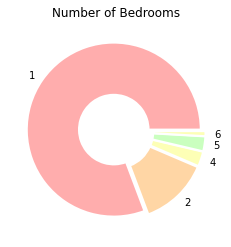

In [52]:
colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#fdffb6']
explode = [0.03] * 5
wedgeprops = {'width': 0.6, 'edgecolor':'w', 'linewidth':2}
plt.pie(bedroom_values, labels=bedroom_labels, colors=colors, explode=explode, wedgeprops=wedgeprops)
plt.title("Number of Bedrooms")
plt.show()

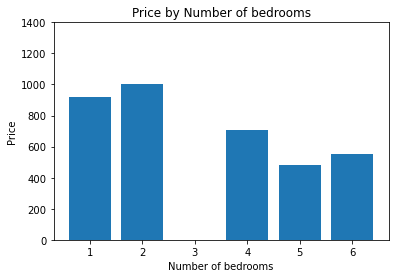

In [58]:
plt.bar(price_by_bedroom.keys(), price_by_bedroom.values())
plt.ylim(0, 1400)
plt.title("Price by Number of bedrooms")
plt.xlabel('Number of bedrooms')
plt.ylabel('Price')
plt.show()

#### other things to consider: 
- number of bedrooms
- number of washrooms 
- number of roommates
- location (how far from uw?)
